In [38]:
from pandas import read_csv
#Load data set
look_back = 24
split = 735-200
series_influ_A_df = read_csv('../temp_data/influA_vietnam_last_10_days.csv', index_col=0, engine='python')
series_influ_A_df = series_influ_A_df.iloc[200:]
train_df = series_influ_A_df.iloc[0:split]
test_df = series_influ_A_df.iloc[split-look_back:]
# series_influ_A_df = series_influ_A_df["case"]

series_influ_A_df = series_influ_A_df.rename(columns= {"Influenza A - All types of surveillance": "case"})
series_influ_A_df = series_influ_A_df[["case", "temp", "tempmax", "dew","windspeed"]]

In [39]:
def exponential_moving_average(data, span):
    return data.ewm(span=span, adjust=False).mean()

In [40]:
series_influ_A_df = series_influ_A_df.dropna()
span = 52  # Bạn có thể điều chỉnh độ dài span tùy ý
series_influ_A_df['case'] = exponential_moving_average(series_influ_A_df['case'], span)
series_influ_A_df = series_influ_A_df.astype('float32')
series_influ_A_df = series_influ_A_df.values
# normalize the dataset
from sklearn.preprocessing import MinMaxScaler, RobustScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(series_influ_A_df)
# scaler = RobustScaler()
# dataset = scaler.fit_transform(series_influ_A_df)
# Create Training and Test

train = dataset[:split, :]
test = dataset[split-look_back:, :]

import numpy as np
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [41]:
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras import Input


model = Sequential([
    LSTM(units=128, activation='relu', return_sequences=True, input_shape=(look_back,5)),
    LSTM(units = 64, activation='relu', return_sequences = True),
     LSTM(units=32, activation='relu'),
      Dense(units=16, activation='relu'),
    Dense(units=5, activation='sigmoid' )
])

# # Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2, validation_data=(testX, testY))

c:\Users\nghiemxuan\Desktop\nghiem\GR3\GR3\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
511/511 - 9s - 18ms/step - loss: 0.0373 - val_loss: 0.0181
Epoch 2/100
511/511 - 4s - 8ms/step - loss: 0.0222 - val_loss: 0.0206
Epoch 3/100
511/511 - 4s - 8ms/step - loss: 0.0154 - val_loss: 0.0166
Epoch 4/100
511/511 - 4s - 8ms/step - loss: 0.0134 - val_loss: 0.0160
Epoch 5/100
511/511 - 4s - 8ms/step - loss: 0.0117 - val_loss: 0.0149
Epoch 6/100
511/511 - 4s - 8ms/step - loss: 0.0116 - val_loss: 0.0153
Epoch 7/100
511/511 - 4s - 8ms/step - loss: 0.0111 - val_loss: 0.0155
Epoch 8/100
511/511 - 4s - 9ms/step - loss: 0.0107 - val_loss: 0.0133
Epoch 9/100
511/511 - 4s - 8ms/step - loss: 0.0109 - val_loss: 0.0137
Epoch 10/100
511/511 - 4s - 8ms/step - loss: 0.0103 - val_loss: 0.0145
Epoch 11/100
511/511 - 5s - 9ms/step - loss: 0.0098 - val_loss: 0.0143
Epoch 12/100
511/511 - 4s - 8ms/step - loss: 0.0099 - val_loss: 0.0155
Epoch 13/100
511/511 - 5s - 10ms/step - loss: 0.0099 - val_loss: 0.0189
Epoch 14/100
511/511 - 4s - 9ms/step - loss: 0.0097 - val_loss: 0.0130
Epoch 15/100


In [47]:
from sklearn.metrics import mean_squared_error
# [[1,3]] :shape 1,2
def predict_one(X, model):
    X= np.array([X])
    predicted = model.predict(X, verbose=0)
    return predicted[0]


#X_start: [[1,3]]
def predict(X_start, num_weeks, model):
    result = []
    X=np.array([X_start])
    for i in range(num_weeks):
        predicted = predict_one(X[i], model)
        result.append(predicted)
        X_continue = np.vstack((X[-1][1:], predicted.reshape(1,5)))
        X = np.append(X, [X_continue], axis=0)
    import json
    # with open('./X.json', 'w') as f:
    #     json.dump(X.tolist(), f)
    return result
    
# make predictions
# testPredict = model.predict(testX)
testPredict = predict(testX[0], len(test)-look_back, model)
# invert predictions
testPredict = scaler.inverse_transform(testPredict)
testY_ = scaler.inverse_transform(testY)
# calculate root mean squared error
testScore = np.sqrt(mean_squared_error(testY_, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 2.59 RMSE


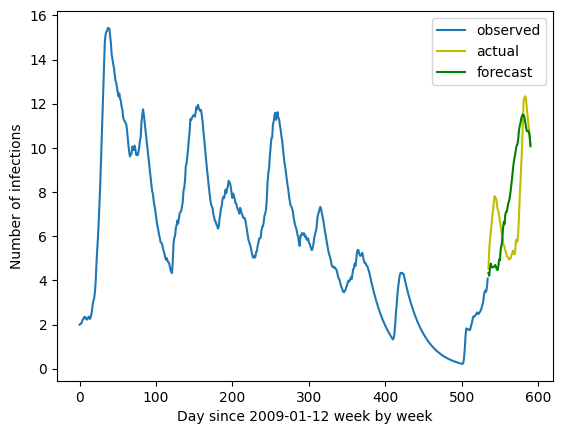

In [48]:

import matplotlib.pyplot as plt
# (x,3)
testPredictPlot = np.empty([dataset.shape[0]])
testPredictPlot[:] = np.nan
testPredictPlot[len(train):len(dataset)] = testPredict[:,0].reshape(-1)
testPlot = np.empty([dataset.shape[0]])
testPlot[:] = np.nan
testPlot[len(train):len(dataset)] = scaler.inverse_transform(test[look_back:])[:,0].reshape(-1)
plt.plot(scaler.inverse_transform(train)[:,0].reshape(-1), label="observed")
plt.plot(testPlot, "-y", label="actual")
plt.plot(testPredictPlot, color = 'green', label="forecast")
plt.xlabel("Day since 2009-01-12 week by week")
plt.ylabel("Number of infections")
plt.legend(["observed", "actual", "forecast"])
plt.show()

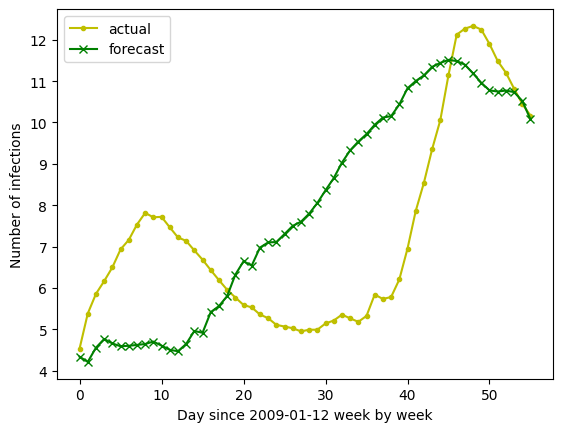

In [49]:

import matplotlib.pyplot as plt
# (x,3)
testPredictPlot = np.empty([testX.shape[0]])
testPredictPlot[:] = np.nan
testPredictPlot[:] = testPredict[:,0].reshape(-1)
testPlot = np.empty([testX.shape[0]])
testPlot[:] = np.nan
testPlot[:] = scaler.inverse_transform(test[look_back:])[:,0].reshape(-1)
# plt.plot(scaler.inverse_transform(train)[:,0].reshape(-1), label="observed")
plt.plot(testPlot, "-y", label="actual", marker= '.')
plt.plot(testPredictPlot, color = 'green', label="forecast", marker='x')
plt.xlabel("Day since 2009-01-12 week by week")
plt.ylabel("Number of infections")
plt.legend(["actual", "forecast"])
plt.show()

In [50]:
model.save("../model/stack_lstm_100epoch_24_ema_sigmoid.keras")